In [1]:
# forehand, backhand, serve, smash
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU 사용 가능')
else:
    device = 'cpu'
    print('GPU 사용 불가')

GPU 사용 가능


In [2]:
# 학습 추이 기록

def init_log():
    plt.rc('font', size = 10)
    # 모든 log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력

    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = f'Epoch: {last(iter_log):3} | T_Loss {train_loss:5} | T_acc {train_acc:5} | V_Loss {val_loss:5} | V_acc. {val_acc:5} | Time {time_spent:5}'

    log_stack.append(log_str)

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [3]:
import numpy as np
import random

# train dataset 집어넣기
forehand_dataset = []
backhand_dataset = []
backslice_dataset = []
forevolley_dataset = []
backvolley_dataset = []
smash_dataset = []
serve_dataset = []

def load_dataset(name, index):
    forehand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Forehand_sampling_train_dataset.npy')
    backhand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Backhand_sampling_train_dataset.npy')
    backslice = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackSlice_sampling_train_dataset.npy')
    forevolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_ForeVolley_sampling_train_dataset.npy')
    backvolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackVolley_sampling_train_dataset.npy')
    smash = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Smash_sampling_train_dataset.npy')
    serve = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Serve_sampling_train_dataset.npy')

    for i in forehand:
        forehand_dataset.append({'key':index, 'value':i})
    for i in backhand:
        backhand_dataset.append({'key':index, 'value':i})
    for i in backslice:
        backslice_dataset.append({'key':index, 'value':i})
    for i in forevolley:
        forevolley_dataset.append({'key':index, 'value':i})
    for i in backvolley:
        backvolley_dataset.append({'key':index, 'value':i})
    for i in smash:
        smash_dataset.append({'key':index, 'value':i})
    for i in serve:
        serve_dataset.append({'key':index, 'value':i})

load_dataset('Federer', 0)
load_dataset('Nadal_inv', 1)
load_dataset('Djokovic', 2)
load_dataset('Sinner', 3)
load_dataset('Tsitsipas', 4)
load_dataset('Zverev', 5)
load_dataset('Murray', 6)
load_dataset('Alcaraz', 7)
load_dataset('Rune', 8)
load_dataset('Shapovalov_inv', 9)

random.shuffle(forehand_dataset)
random.shuffle(backhand_dataset)
random.shuffle(backslice_dataset)
random.shuffle(forevolley_dataset)
random.shuffle(backvolley_dataset)
random.shuffle(smash_dataset)
random.shuffle(serve_dataset)

dataset = forehand_dataset
#dataset = backhand_dataset
#dataset = serve_dataset
#dataset = backslice_dataset
#dataset = forevolley_dataset
#dataset = backvolley_dataset
#dataset = smash_dataset
swing_type = 'forehand'

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Pytorch에서 데이터를 불러오고, 전처리하는 클래스

class MyDataset(Dataset):
    def __init__(self, seq_data):
        self.X = []
        self.y = []
        for dic in seq_data:
            self.X.append(dic['value'])
            self.y.append(dic['key'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
            return len(self.X)

In [5]:
split_ratio = [0.8, 0.2]
train_len = round(len(dataset) * split_ratio[0])
val_len = round(len(dataset) * split_ratio[1])
print(f'{train_len}, {val_len}')

1761, 440


In [6]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=4)
val_loader = DataLoader(valid_data, batch_size=4)

In [7]:
# forehand, backhand, serve
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 2048, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2048, hidden_size = 512, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=512, hidden_size = 256, num_layers=1, batch_first=True)
        self.fc = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.3)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout1(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:,-1,:])
        return x

In [8]:
# backslice
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size = 64, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size = 16, num_layers=1, batch_first=True)
        self.fc = nn.Linear(16, 10)
        self.dropout1 = nn.Dropout(0.3)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout1(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:,-1,:])
        return x

In [9]:
# forevolley, backvolley
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 64, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size = 32, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=32, hidden_size = 16, num_layers=1, batch_first=True)
        self.fc = nn.Linear(16, 10)
        self.dropout1 = nn.Dropout(0.3)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout1(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:,-1,:])
        return x

In [10]:
# smash
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=256, hidden_size = 128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.3)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm6(x)
        x = self.fc(x[:,-1,:])
        return x

In [11]:
# 모델 초기화
import matplotlib.pyplot as plt
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global model, loss_fn, optim
    model = LSTM_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), lr=0.000005)

# epoch count 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

In [12]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
from tqdm import tqdm
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for 문을 나오면 1 epoch 완료)
    for _data, _label in tqdm(data_loader, desc='Training'):
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            model.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            model.eval()
    
        result = model(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로 
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출 / 첫번째 인자는 값을 두번째 인자는 index를 돌려준다.
    
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
    
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기로 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
    
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # Label == GT(실제 환경 데이터)인 개수
        acc_partial = acc_partial / len(label) # (TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Accuracy 기록

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습 추이 그래프, 모든 GT와 Label 값 for 컨퓨전 행렬
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [15]:
# Training Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 10

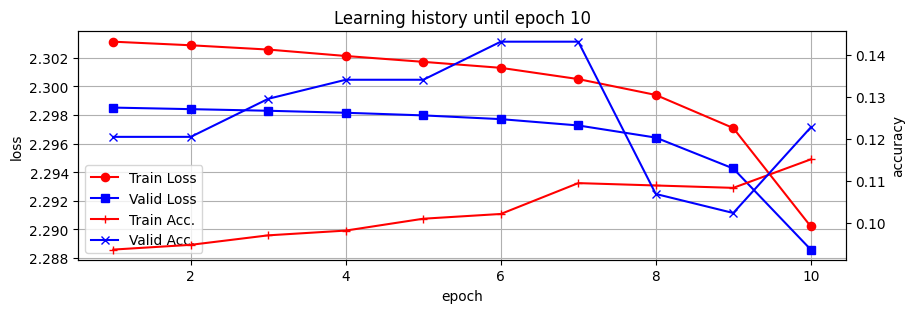

Epoch:  10 | T_Loss  2.29 | T_acc 0.115 | V_Loss 2.289 | V_acc. 0.123 | Time 2.498
Epoch:   9 | T_Loss 2.297 | T_acc 0.108 | V_Loss 2.294 | V_acc. 0.102 | Time 2.276
Epoch:   8 | T_Loss 2.299 | T_acc 0.109 | V_Loss 2.296 | V_acc. 0.107 | Time 2.293
Epoch:   7 | T_Loss 2.301 | T_acc 0.109 | V_Loss 2.297 | V_acc. 0.143 | Time 2.462
Epoch:   6 | T_Loss 2.301 | T_acc 0.102 | V_Loss 2.298 | V_acc. 0.143 | Time 2.403
Epoch:   5 | T_Loss 2.302 | T_acc 0.101 | V_Loss 2.298 | V_acc. 0.134 | Time 2.217
Epoch:   4 | T_Loss 2.302 | T_acc 0.098 | V_Loss 2.298 | V_acc. 0.134 | Time 2.147
Epoch:   3 | T_Loss 2.303 | T_acc 0.097 | V_Loss 2.298 | V_acc.  0.13 | Time 2.284
Epoch:   2 | T_Loss 2.303 | T_acc 0.095 | V_Loss 2.298 | V_acc.  0.12 | Time 2.562
Epoch:   1 | T_Loss 2.303 | T_acc 0.094 | V_Loss 2.299 | V_acc.  0.12 | Time 2.573


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 791.67it/s]


 Training completed!


In [21]:
# Training Iteration
import time
loss_result = []
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    test_acc = test_data()
    loss_result.append(f'tloss : {tloss:.5} | tacc : {tacc:.5} | vloss : {vloss:.5} | vacc : {vacc:.5} | test : {test_acc}')
    if test_acc < 35:
        torch.save(model.state_dict(), f'./model_info/similarity_model_{swing_type}_{test_acc}_{tloss:.5}_{tacc:.5}_{vloss:.5}_{vacc:.5}')

print('\n Training completed!')

In [22]:
cnt = 0
with open(f"similarity_model_{swing_type}_train_result.txt", "w") as f:
    for i in loss_result:
        cnt += 1
        f.write(str(cnt))
        f.write(" ")
        f.write(str(i))
        f.write(" \n")

In [12]:
# 모델 저장하기
torch.save(model.state_dict(), f'./model_info/similarity_model_{swing_type}_{tloss:.5}_{tacc:.5}_{vloss:.5}_{vacc:.5}')

<b>Test

In [14]:
model.load_state_dict(torch.load('./similarity_model_forehand_0.0035575_0.99887_0.48779_0.94773_32_399', map_location=device))

LSTM_model(
  (lstm1): LSTM(100, 2048, batch_first=True)
  (lstm2): LSTM(2048, 512, batch_first=True)
  (lstm6): LSTM(512, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)

In [17]:
test_forehand_dataset = []
test_backhand_dataset = []
test_backslice_dataset = []
test_forevolley_dataset = []
test_backvolley_dataset = []
test_smash_dataset = []
test_serve_dataset = []

def load_test_dataset(name):
    forehand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Forehand_sampling_test_dataset.npy')
    backhand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Backhand_sampling_test_dataset.npy')
    backslice = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackSlice_sampling_test_dataset.npy')
    forevolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_ForeVolley_sampling_test_dataset.npy')
    backvolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackVolley_sampling_test_dataset.npy')
    smash = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Smash_sampling_test_dataset.npy')
    serve = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Serve_sampling_test_dataset.npy')

    for i in forehand:
        test_forehand_dataset.append({'key':0, 'value':i})
    for i in backhand:
        test_backhand_dataset.append({'key':1, 'value':i})
    for i in backslice:
        test_backslice_dataset.append({'key':2, 'value':i})
    for i in forevolley:
        test_forevolley_dataset.append({'key':3, 'value':i})
    for i in backvolley:
        test_backvolley_dataset.append({'key':4, 'value':i})
    for i in smash:
        test_smash_dataset.append({'key':5, 'value':i})
    for i in serve:
        test_serve_dataset.append({'key':6, 'value':i})

    return len(test_forehand_dataset)

federer_len = load_test_dataset('Federer')
nadal_len = load_test_dataset('Nadal_inv')
sinner_len = load_test_dataset('Sinner')
tsitsipas_len = load_test_dataset('Tsitsipas')
murray_len = load_test_dataset('Murray')
shapovalov_len = load_test_dataset('Shapovalov_inv')

print(federer_len,nadal_len,sinner_len,tsitsipas_len,murray_len,shapovalov_len)

test_dataset = MyDataset(test_forehand_dataset)
test_dataset = DataLoader(test_dataset)

152 188 218 287 329 399


In [18]:
def test_data():
    test_data_list = []
    model.eval()

    for data, label in tqdm(test_dataset):
        data = data.to(device)
        with torch.no_grad():
            classification_result = model(data)
            classification_result = F.softmax(classification_result, dim=1)
            out_result, out = torch.max(classification_result, 1)
    
            if out.item() == 0: 
                test_data_list.append('Federer')
            elif out.item() == 1: 
                test_data_list.append('Nadal')
            elif out.item() == 2: 
                test_data_list.append('Djokovic')
            elif out.item() == 3: 
                test_data_list.append('Sinner')
            elif out.item() == 4: 
                test_data_list.append('Tsitsipas')
            elif out.item() == 5: 
                test_data_list.append('Zverev')
            elif out.item() == 6: 
                test_data_list.append('Murray')
            elif out.item() == 7: 
                test_data_list.append('Alcaraz')
            elif out.item() == 8: 
                test_data_list.append('Rune')
            elif out.item() == 9: 
                test_data_list.append('Shapovalov')

    cnt = 0
    check = 0
    
    for i in test_data_list:
        cnt += 1
        if cnt <= federer_len:
            if i != 'Federer':
                check += 1
        elif cnt <= nadal_len:
            if i != 'Nadal':
                check += 1
        elif cnt <= sinner_len:
            if i != 'Sinner':
                check += 1
        elif cnt <= tsitsipas_len:
            if i != 'Tsitsipas':
                check += 1
        elif cnt <= murray_len:
            if i != 'Murray':
                check += 1
        elif cnt <= shapovalov_len:
            if i != 'Shapovalov':
                check += 1
    
    return check

In [19]:
test_data_list = []
model.eval()

for data, label in tqdm(test_dataset):
    data = data.to(device)
    with torch.no_grad():
        classification_result = model(data)
        classification_result = F.softmax(classification_result, dim=1)
        out_result, out = torch.max(classification_result, 1)

        if out.item() == 0: 
            test_data_list.append('Federer')
        elif out.item() == 1: 
            test_data_list.append('Nadal')
        elif out.item() == 2: 
            test_data_list.append('Djokovic')
        elif out.item() == 3: 
            test_data_list.append('Sinner')
        elif out.item() == 4: 
            test_data_list.append('Tsitsipas')
        elif out.item() == 5: 
            test_data_list.append('Zverev')
        elif out.item() == 6: 
            test_data_list.append('Murray')
        elif out.item() == 7: 
            test_data_list.append('Alcaraz')
        elif out.item() == 8: 
            test_data_list.append('Rune')
        elif out.item() == 9: 
            test_data_list.append('Shapovalov')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 569.19it/s]


In [20]:
cnt = 0
check = 0

for i in test_data_list:
    cnt += 1
    if cnt <= federer_len:
        if i != 'Federer':
            check += 1
            print('Federer', i)
    elif cnt <= nadal_len:
        if i != 'Nadal':
            check += 1
            print('Nadal', i)
    elif cnt <= sinner_len:
        if i != 'Sinner':
            check += 1
            print('Sinner', i)
    elif cnt <= tsitsipas_len:
        if i != 'Tsitsipas':
            check += 1
            print('Tsitsipas', i)
    elif cnt <= murray_len:
        if i != 'Murray':
            check += 1
            print('Murray', i)
    elif cnt <= shapovalov_len:
        if i != 'Shapovalov':
            check += 1
            print('Shapovalov', i)

print(check)

Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Sinner
Federer Si